In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid")
#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def ethnicity_multi_labels(x):
    if "ASIAN" in x:
        return "ASIAN"
    elif "AFRICAN" in x:
        return "BLACK"
    elif "HISPANIC" in x:
        return "HISPANIC"
    elif "WHITE" in x:
        return "WHITE"
    elif "NATIVE" in x:
        return "OTHER"
        return "NATIVE"
    else:
        return "OTHER"

def ethnicity_binary_labels(x):
    if "ASIAN" in x or "AFRICAN" in x or "HISPANIC" in x or "NATIVE" in x: 
        return "NON-WHITE"
    elif "WHITE" in x:
        return "WHITE"
    else:
        return "OTHER"

def get_ethnicity_dataset(df, path_out=None):
    df["ETHNICITY_LABEL"] = df["ETHNICITY"].apply(lambda x:ethnicity_binary_labels(x))
    df_ethnicity = df[["ETHNICITY_LABEL","TEXT"]]
    if path_out:
        df_ethnicity.to_csv(path_out,index=False, sep="\t", header=False)
        
    return df_ethnicity

def get_mortality_dataset(df, path_out=None):
    df["EXPIRE"] = df["HOSPITAL_EXPIRE_FLAG"]
    df_mortality = df[["EXPIRE","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"]]
    if path_out:
        df_mortality.to_csv(path_out,index=False, sep="\t", header=False)
    return df_mortality

def get_readmissions_dataset(mimic_path, patients_df, path_out=None):
    admissions_df = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
    data = []
    READMISSION_DELTA = float("inf")
    for _, patient in patients_df.iterrows():
        adm = admissions_df[admissions_df["SUBJECT_ID"] == patient["SUBJECT_ID"]]
        if len(adm) > 1:
            admission_times = list(adm.sort_values("ADMITTIME")["ADMITTIME"])
            for i in range(len(admission_times)-1):
                d1 = admission_times[i]
                d2 = admission_times[i+1]
                d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
                d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
                delta = d2 - d1
                if delta.days < READMISSION_DELTA:
                    data.append([1,patient["TEXT"],patient["GENDER"]])
                    break             
        else:
            data.append([0,patient["TEXT"],patient["GENDER"], 
                           patient["ETHNICITY_LABEL"], patient["ETHNICITY_BINARY"]])
    readm_df = pd.DataFrame(data, columns=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
    if path_out:
        readm_df.to_csv(path_out,index=False, sep="\t", header=False)    
    return readm_df
    

def extract_patients(mimic_path, sample_size=None, path_out=None):
    all_notes = pd.read_csv(mimic_path+"NOTEEVENTS.CSV.gz")
    all_patients = pd.read_csv(mimic_path+"PATIENTS.CSV.gz")
    all_admissions = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
    #filter relevant columns
    notes = all_notes[["TEXT"]]
    notes["TEXT"] = notes["TEXT"].apply(lambda x: x.replace("\n","").replace("\t","").lower())
    patients = all_patients[["SUBJECT_ID","GENDER"]]
    admissions = all_admissions[["INSURANCE","ETHNICITY","HOSPITAL_EXPIRE_FLAG"]]
    #subsample?
    if sample_size:        
        patients = patients[:sample_size]
    #join dataframes
    patients = patients.join(admissions, how="inner", on="SUBJECT_ID",rsuffix="A_")
    patients = patients.join(notes, how="inner", on="SUBJECT_ID",rsuffix="N_")
    patients["ETHNICITY_LABEL"] = patients["ETHNICITY"].apply(lambda x:ethnicity_multi_labels(x))
    patients["ETHNICITY_BINARY"] = patients["ETHNICITY"].apply(lambda x:ethnicity_binary_labels(x))
    
    if path_out:
        patients.to_csv(path_out,index=False, sep="\t", header=False)    
    
    return patients

def subsample(df, label, ratio=1, path_out=None):
    minority_size = min(df.groupby(label).size())
    minority_class = np.argmin(df.groupby(label).size())
    
    majority_size = int(minority_size * ratio)
    majority_class = np.argmax(df.groupby(label).size())
    all_size = minority_size + majority_size
  
    print("{} > Minority: {}/{} | Majority: {}/{}".format(label, minority_size, all_size,
                                                           majority_size,all_size))

    df_maj = df[df[label] == majority_class].head(majority_size)
    df_min = df[df[label] == minority_class]
    df_all = df_min.append(df_maj, ignore_index=True)
    if path_out:
        df_all.to_csv(path_out,index=False, sep="\t", header=False)    
    return df_all

In [5]:
raw_data_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
out_data_path = "/Users/samir/Dev/projects/MIMIC/MIMIC/DATA/input/"

## Extract Data

In [7]:
# PATIENT_SAMPLE_SIZE = 20000
# mini_patients = extract_patients(raw_data_path, PATIENT_SAMPLE_SIZE,out_data_path+"mini_patients.csv")
patients = extract_patients(raw_data_path, None,out_data_path+"patients.csv")
patients
# col_names = ["SUBJECT_ID","GENDER","INSURANCE","ETHNICITY","HOSPITAL_EXPIRE_FLAG","TEXT","ETHNICITY_LABEL","ETHNICITY_BINARY"]
# mini_patients = pd.read_csv(out_data_path+"mini_patients.csv", header=None, 
#                             sep="\t", names=col_names)
# mini_patients

/Users/samir/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/samir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SUBJECT_ID,GENDER,INSURANCE,ETHNICITY,HOSPITAL_EXPIRE_FLAG,TEXT,ETHNICITY_LABEL,ETHNICITY_BINARY
0,249,F,Medicaid,BLACK/AFRICAN AMERICAN,0,admission date: [**2149-6-2**] discharg...,BLACK,NON-WHITE
1,250,F,Medicare,UNKNOWN/NOT SPECIFIED,0,admission date: [**2149-9-2**] discharg...,OTHER,OTHER
2,251,M,Medicaid,BLACK/AFRICAN AMERICAN,0,admission date: [**2193-1-8**] d...,BLACK,NON-WHITE
3,252,M,Medicare,OTHER,0,admission date: [**2133-9-3**] d...,OTHER,OTHER
4,253,F,Private,HISPANIC OR LATINO,0,admission date: [**2103-8-16**] discharge...,HISPANIC,NON-WHITE
...,...,...,...,...,...,...,...,...
46515,44089,M,Medicare,UNKNOWN/NOT SPECIFIED,0,admission date: [**2176-1-21**] dischar...,OTHER,OTHER
46516,44115,F,Private,WHITE,0,admission date: [**2140-6-28**] dischar...,WHITE,WHITE
46517,44123,F,Private,WHITE,0,admission date: [**2116-8-10**] ...,WHITE,WHITE
46518,44126,F,Medicare,WHITE,0,admission date: [**2201-5-26**] ...,WHITE,WHITE


## Mortality

In [10]:
# df_mortality = get_mortality_dataset(mini_patients, out_data_path+"mini_mortality.csv")
df_mortality = get_mortality_dataset(patients, out_data_path+"mortality.csv")
df_mortality

,EXPIRE,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,0,admission date: [**2149-6-2**] discharg...,F,BLACK,NON-WHITE
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,0,admission date: [**2133-9-3**] d...,M,OTHER,OTHER
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
46515,0,admission date: [**2176-1-21**] dischar...,M,OTHER,OTHER
46516,0,admission date: [**2140-6-28**] dischar...,F,WHITE,WHITE
46517,0,admission date: [**2116-8-10**] ...,F,WHITE,WHITE
46518,0,admission date: [**2201-5-26**] ...,F,WHITE,WHITE


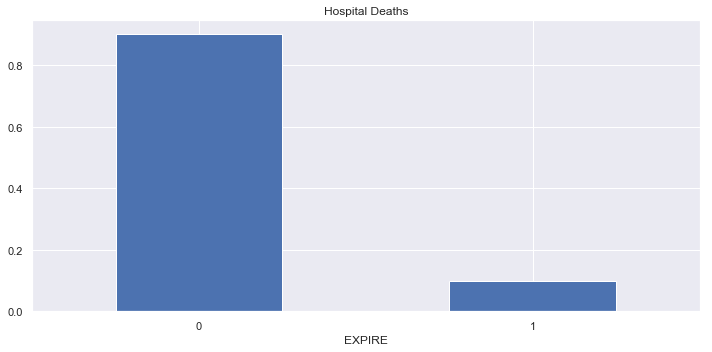

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

df_mg = df_mortality.groupby("EXPIRE").size()/df_mortality.groupby("EXPIRE").size().sum()
df_mg.plot(ax=ax,kind="bar", title="Hospital Deaths", rot=0)
plt.tight_layout()

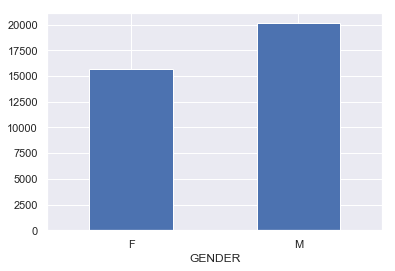

In [12]:
df_mortality.groupby("GENDER").size().plot(kind="bar", rot=0)

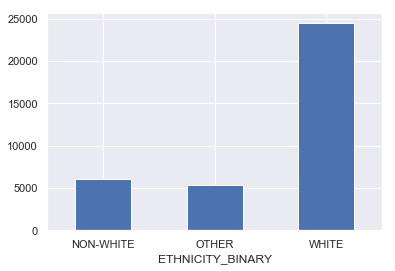

In [13]:
df_mortality.groupby("ETHNICITY_BINARY").size().plot(kind="bar", rot=0)

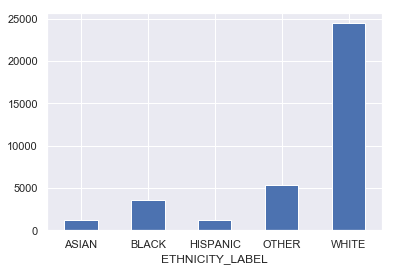

In [14]:
df_mortality.groupby("ETHNICITY_LABEL").size().plot(kind="bar", rot=0)

In [15]:
#subsample majority class (negative)
# df_mortality_balanced = subsample(df_mortality,"EXPIRE",1, out_data_path+"/mini_mortality_balanced.csv")


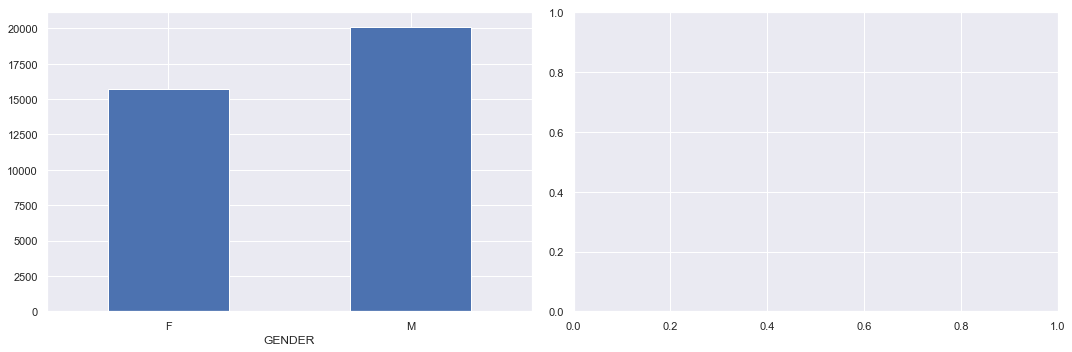

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_mortality.groupby("GENDER").size().plot(kind="bar", rot=0, ax=ax[0])
# df_mortality_balanced.groupby("GENDER").size().plot(kind="bar", rot=0, ax=ax[1],color="r")
plt.tight_layout()

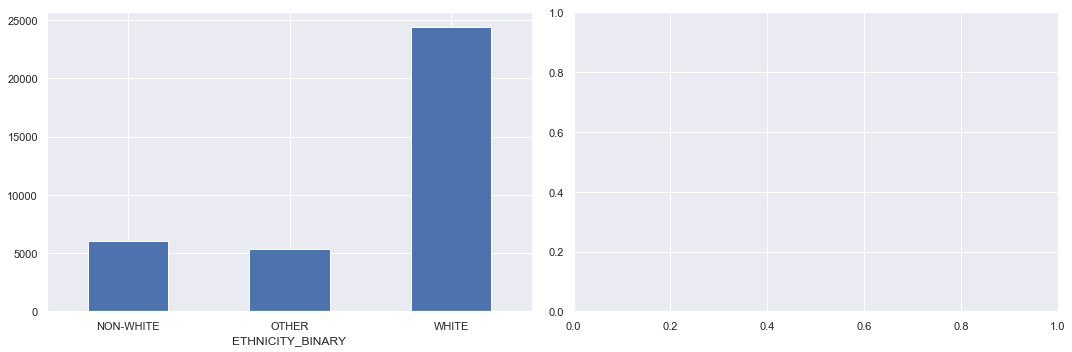

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_mortality.groupby("ETHNICITY_BINARY").size().plot(kind="bar", rot=0, ax=ax[0])
# df_mortality_balanced.groupby("ETHNICITY_BINARY").size().plot(kind="bar", rot=0, ax=ax[1],color="r")
plt.tight_layout()

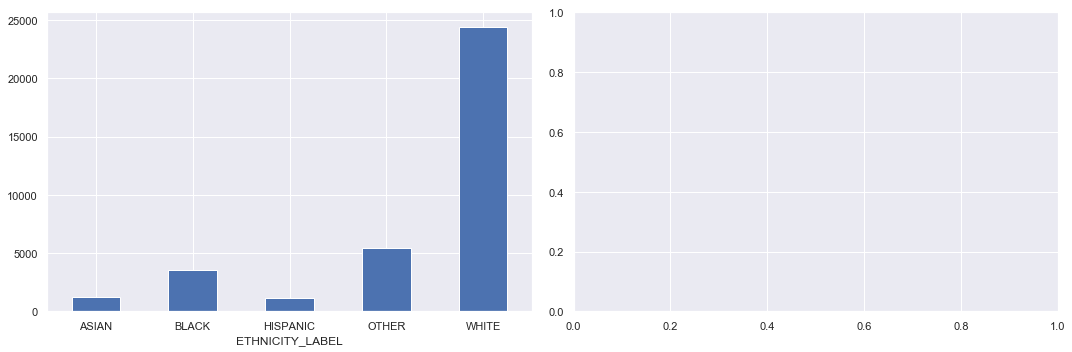

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_mortality.groupby("ETHNICITY_LABEL").size().plot(kind="bar", rot=0, ax=ax[0])
# df_mortality_balanced.groupby("ETHNICITY_LABEL").size().plot(kind="bar", rot=0, ax=ax[1],color="r")
plt.tight_layout()

## Readmissions

In [9]:
mimic_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
# df_readm = get_readmissions_dataset(mimic_path, mini_patients, path_out=out_data_path+"/mini_readmissions.csv")
df_readm = get_readmissions_dataset(mimic_path, patients, path_out=out_data_path+"/readmissions.csv")
df_readm

,READMISSION,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,1,admission date: [**2149-6-2**] discharg...,F,None,None
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,1,admission date: [**2133-9-3**] d...,M,None,None
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
35827,0,admission date: [**2176-1-21**] dischar...,M,OTHER,OTHER
35828,0,admission date: [**2140-6-28**] dischar...,F,WHITE,WHITE
35829,0,admission date: [**2116-8-10**] ...,F,WHITE,WHITE
35830,0,admission date: [**2201-5-26**] ...,F,WHITE,WHITE


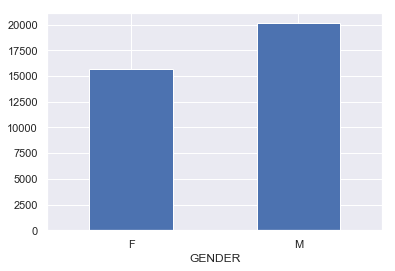

In [20]:
df_readm.groupby("GENDER").size().plot(kind="bar", rot=0)

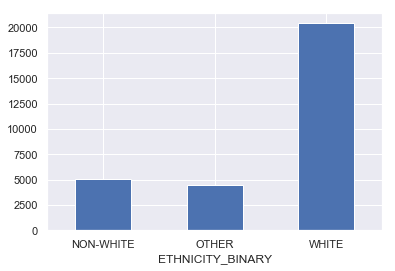

In [21]:
df_readm.groupby("ETHNICITY_BINARY").size().plot(kind="bar", rot=0)

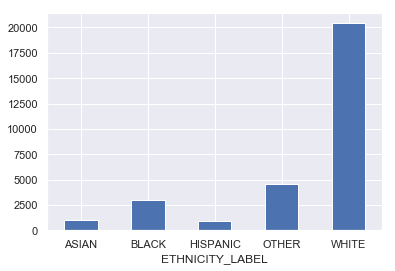

In [22]:
df_readm.groupby("ETHNICITY_LABEL").size().plot(kind="bar", rot=0)

In [23]:
#subsample majority class (negative)
# df_readm_balanced = subsample(df_readm,"READMISSION",1, out_data_path+"/mini_readmissions_balanced.csv")


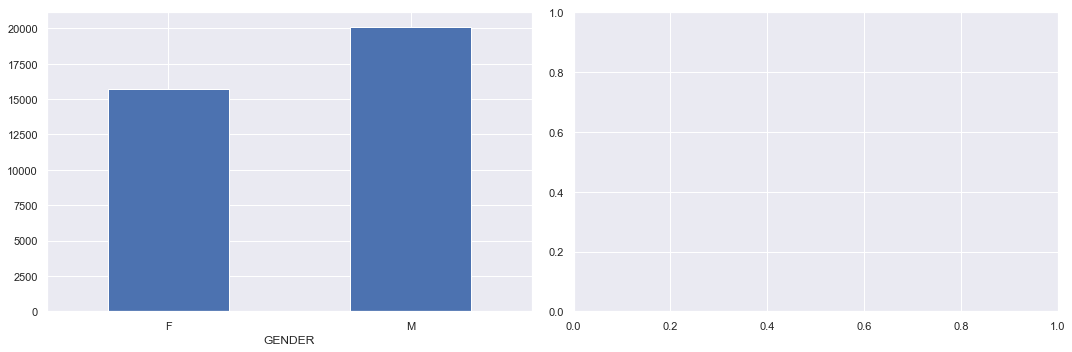

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_readm.groupby("GENDER").size().plot(kind="bar", rot=0, ax=ax[0])
# df_readm_balanced.groupby("GENDER").size().plot(kind="bar", rot=0, ax=ax[1],color="r")
plt.tight_layout()

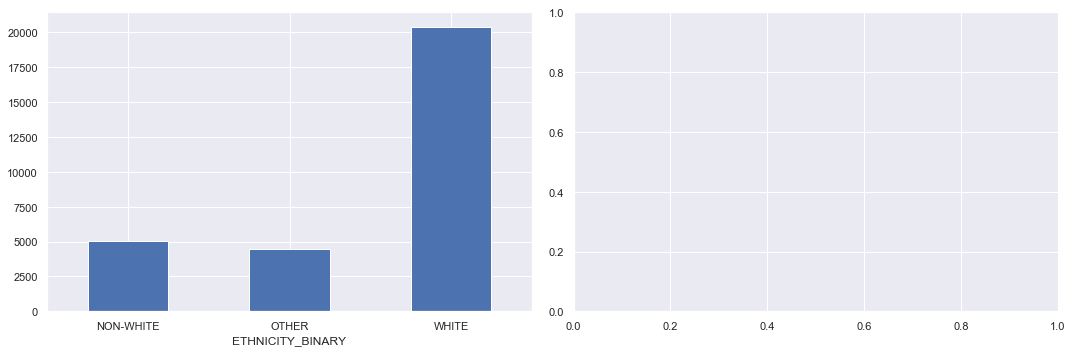

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_readm.groupby("ETHNICITY_BINARY").size().plot(kind="bar", rot=0, ax=ax[0])
# df_readm_balanced.groupby("ETHNICITY_BINARY").size().plot(kind="bar", rot=0, ax=ax[1],color="r")
plt.tight_layout()

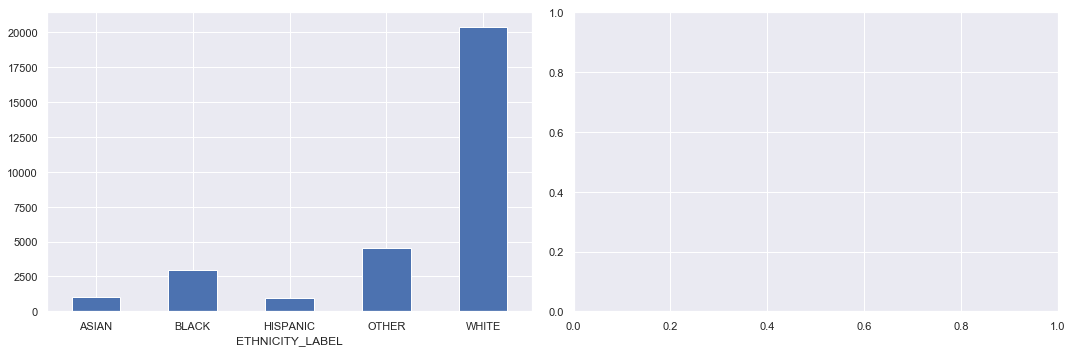

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_readm.groupby("ETHNICITY_LABEL").size().plot(kind="bar", rot=0, ax=ax[0])
# df_readm_balanced.groupby("ETHNICITY_LABEL").size().plot(kind="bar", rot=0, ax=ax[1],color="r")
plt.tight_layout()